In [27]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from pandas_confusion import ConfusionMatrix

%matplotlib inline

In [51]:
## feature_names -- DayOfWeek,HourOfDay,Month,PdDistrict,ZipCode, Address, IsIntersection

def HourOfDay(df):
    ft = df.map(lambda x: x.hour)
    feat = pd.cut(ft, bins = [0,3,6,9,12,15,18,21,24], right=False)
    feat.name = 'HourOfDay'
    return feat

def Month(df):
    feat = df.map(lambda x: x.strftime("%B"))
    feat.name = 'Month'
    return feat

def ZipCode(df):
    count = df.groupby(['ZipCode']).size()
    cat_count = df.groupby(['ZipCode', 'Target']).size()
    odds = cat_count.div(count, level='ZipCode').reset_index()
    odds.columns = ['ZipCode', 'Target', 'Odds']
    dfm = df.merge(odds, how='left', on=['ZipCode', 'Target'])
    
    feat = dfm['Odds']
    feat.name = 'ZipCode'
    return feat

def IsIntersection(df):
    feat = df.apply(lambda x: 0 if x.find("/") < 0 else 1)
    feat.name = 'IsIntersection'
    return feat

def Lng(df):
    minX, maxX = df.min(), df.max()
    feat = df.apply(lambda x: (x-minX)/(maxX-minX))
    feat.name = 'Lng'
    return feat

def Lat(df):
    minY, maxY = df.min(), df.max()
    feat = df.apply(lambda x: (x-minY)/(maxY-minY))
    feat.name = 'Lat'
    return feat

def build_dataset(data):
    data['Dates'] = pd.to_datetime(data['Dates'])

    features = pd.DataFrame(index=data.index)
    features = features.join(data['DayOfWeek'])
    features = features.join(HourOfDay(data['Dates']))
    features = features.join(Month(data['Dates']))
    features = features.join(data['PdDistrict'])
    features = features.join(ZipCode(data[['ZipCode','Target']]))
    features = features.join(Lat(data['Y']))
    features = features.join(Lng(data['X']))
    features = features.join(IsIntersection(data['Address']))
        
    return features, data['Target']

In [52]:
train_data = pd.read_csv('data/train-A.csv', quotechar='"')
test_data  = pd.read_csv('data/train-B.csv', quotechar='"')

In [53]:
train_features,y_train  = build_dataset(train_data)
test_features,y_test    = build_dataset(test_data)

In [54]:
train_features.head(5)

,DayOfWeek,HourOfDay,Month,PdDistrict,ZipCode,Lat,Lng,IsIntersection
0,Wednesday,"[21, 24)",May,NORTHERN,0.080916,0.001276,0.043578,1
1,Wednesday,"[21, 24)",May,NORTHERN,0.166816,0.001276,0.043578,1
2,Wednesday,"[21, 24)",May,NORTHERN,0.107591,0.001770,0.044337,1
3,Wednesday,"[21, 24)",May,NORTHERN,0.322836,0.001778,0.043030,0
4,Wednesday,"[21, 24)",May,PARK,0.176911,0.001217,0.037198,0


In [55]:
d_train = train_features.T.to_dict().values()
d_test = test_features.T.to_dict().values()

vectorizer = DictVectorizer(sparse=True)

X_train = vectorizer.fit_transform(d_train)
X_test  = vectorizer.transform(d_test)

X_train.shape

(614628, 41)

In [62]:
##vectorizer.get_feature_names()

In [63]:
rparams = dict(C=[0.1, 1.0, 10.0, 1.0e2, 1.0e3, 1.0e4, 1.0e5, 1.0e6])

lr = LogisticRegression(penalty='l2', C=1.0e3, max_iter=1000,\
                         multi_class='ovr', n_jobs=-1,\
                         solver='lbfgs', class_weight='balanced', verbose=0) # 

clf = GridSearchCV(lr, param_grid=rparams, scoring='log_loss', n_jobs=1, verbose=2)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1 ...........................................................
[CV] .................................................. C=0.1 -  21.4s
[CV] C=0.1 ...........................................................
[CV] .................................................. C=0.1 -  21.4s
[CV] C=0.1 ...........................................................
[CV] .................................................. C=0.1 -  20.4s
[CV] C=1.0 ...........................................................
[CV] .................................................. C=1.0 -  22.5s
[CV] C=1.0 ...........................................................
[CV] .................................................. C=1.0 -  20.1s
[CV] C=1.0 ...........................................................
[CV] .................................................. C=1.0 -  19.9s
[CV] C=10.0 ..........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=2)

In [64]:
print(clf.best_params_)

{'C': 1000000.0}


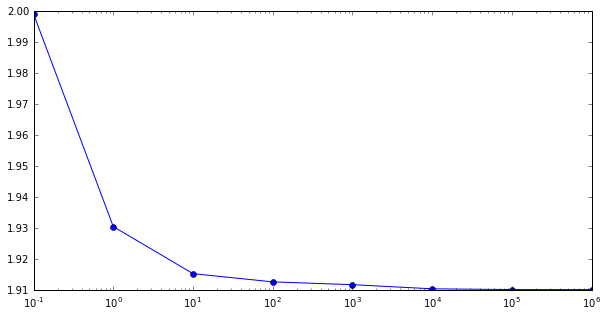

In [65]:
cv_scores = np.zeros(8)
c = np.zeros(8)

rownum = 0
for params, mean_score, scores in clf.grid_scores_:
    c[rownum] = params['C']
    cv_scores[rownum] = -1.0*mean_score
    rownum = rownum + 1

plt.plot(c, cv_scores, '-o')
plt.xscale('log')

In [70]:
predicted = clf.predict(X_test)
expected = y_test
print(accuracy_score(expected, predicted))

0.367510562939


In [71]:
predicted_probs = clf.predict_proba(X_test)
print(log_loss(y_test, predicted_probs))

1.90905750343


In [72]:
cm = ConfusionMatrix(expected, predicted)
cm_stats = cm.to_dataframe().apply(lambda x: x/sum(x), axis=1)
cm_stats.to_csv('data/confusion_matrix_stats.csv')

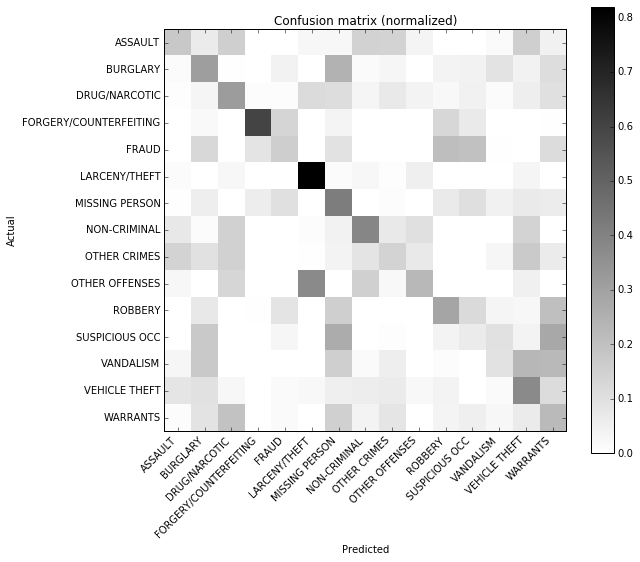

In [73]:
mpl.rcParams['figure.figsize'] = (10.0, 5.0)
cm.plot(normalized=True)